# COURSE: PCA and multivariate neural signal processing
## SECTION: Source separation with GED
### VIDEO: Python: Task-relevant component in EEG data
#### Instructor: sincxpress.com

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy
import scipy.io as sio
from pytopo import topoplotIndie
from filterFGxfun import filterFGx

In [2]:
# Data were collected in a speeded reaction-time task.
# The first 125 trials are correct responses, the next 125 trials are
# incorrect responses.

matfile = sio.loadmat('MATLAB_data_files/CEdata.mat')
EEG = matfile['EEG'][0,0]
EEG['times'] = EEG['times'][0]
EEG['data'] = np.double(EEG['data']) ## higher accuracy with double-precision data

In [18]:
# Apply a narrow band-pass filter centered at 7 Hz with a FWHM of 5 Hz.
# Notice how the results depend on the filter frequency!
centerFreq = 15
freqFWHM = 5

fdata = copy.deepcopy(EEG['data'])
for ti in range(int(EEG['trials'])):
    tmdat = EEG['data'][:,:,ti]
    fdata[:,:,ti] = filterFGx(tmdat,EEG['srate'][0][0],centerFreq,freqFWHM)[0]


# define time ranges for computing the covariance matrix. You can also try
# different ranges to see how the results are affected.
times = [-700,0,700]
tidx0 = np.argmin(np.abs(EEG['times']-times[0]))
tidx1 = np.argmin(np.abs(EEG['times']-times[1]))
tidx2 = np.argmin(np.abs(EEG['times']-times[2]))

In [19]:
## GED on pre-stim vs. post-stim covariances

# extract and vectorize data, and compute covariance matrices
covPre = np.zeros( (EEG['nbchan'][0][0],EEG['nbchan'][0][0]) )
covPst = np.zeros( (EEG['nbchan'][0][0],EEG['nbchan'][0][0]) )

for ti in range(EEG['trials'][0][0]):
    
    # covariance of pre-stim period
    tpre    = fdata[:,tidx0:tidx1,ti] # extract data
    covPre += np.cov(tpre)
    
    # covariance of post-stim period
    tpst    = fdata[:,tidx1:tidx2,ti] # extract data
    covPst += np.cov(tpst)
    
# average covariances by dividing by trials
covPre = covPre/ti
covPst = covPst/ti

### GED
evals,evecs = scipy.linalg.eigh(covPst,covPre)
# sort according to eigenvalues
soidx = np.argsort(evals)[::-1]
evals = evals[soidx]
evecs = evecs[:,soidx]

# initialize maps and time series
maps   = np.zeros( (4,int(EEG['nbchan'])) )
compts = np.zeros( (4,int(EEG['pnts']),int(EEG['trials'])) )
maps.shape

(4, 64)

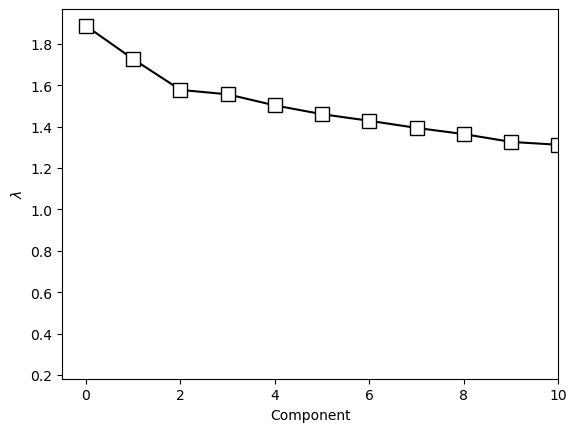

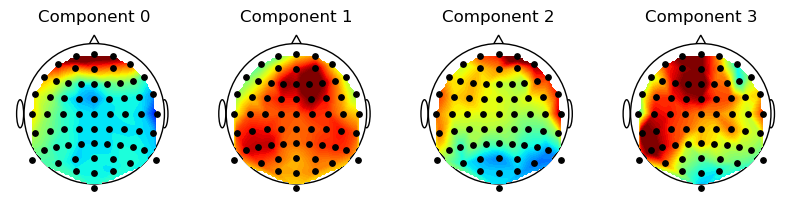

In [20]:
## some plotting
plt.plot(evals,'ks-',markerfacecolor='w',markersize=10)
plt.xlim([-.5,10])
plt.xlabel('Component')
plt.ylabel('$\lambda$')

_,axs = plt.subplots(1,4,figsize=(10,4))

for compi in range(4):
    
    # compute map and adjust sign
    maps[compi,:] = evecs[:,compi].T@covPst
    idx           = np.argmax( np.abs(maps[compi,:]) )
    maps[compi,:] = maps[compi,:] * np.sign(maps[compi,idx])
    topoplotIndie(maps[compi,:],EEG['chanlocs'],f'Component {compi}',axs[compi])
    
    # compute time series
    tmpts = evecs[:,compi].T @ np.reshape(EEG['data'],(EEG['nbchan'][0][0],-1),order='F')
    compts[compi,:,:] = np.reshape( tmpts,(EEG['pnts'][0][0],EEG['trials'][0][0]),order='F' )

plt.show()

In [21]:
# pick two components from visual inspection
comps2analyze = [ 0, 1 ]


## standard TF analysis on channels

# frequencies in Hz
frex = np.linspace(1,20,20)

# time points for baseline and for storing post-analysis TF results
baseidx0 = np.argmin(np.abs(EEG['times'] - -500))
baseidx1 = np.argmin(np.abs(EEG['times'] - -200))

times2save = np.linspace(-400,1300,80)
t2save = np.zeros(80,dtype=int)
for i in range(len(t2save)):
    t2save[i] = np.argmin(np.abs(EEG['times']-times2save[i]))



# convenient to have component time series data as 2D
comp2d = np.reshape(compts[comps2analyze,:,:],(2,-1),order='F')

# initialize time-frequency matrix
ctf = np.zeros((2,2,len(frex),len(t2save)))


# loop over frequencies
for fi in range(len(frex)):
    
    # filter data for both components at this frequency
    filtdat = filterFGx(comp2d,EEG['srate'][0][0],frex[fi],4)[0]
    
    # loop over components
    for compi in range(2):
        
        # compute power time series as envelope of Hilbert transform
        as1 = np.reshape(scipy.signal.hilbert(filtdat[compi,:]) ,(EEG['pnts'][0][0],EEG['trials'][0][0]),order='F')
        
        # trial-average power for each condition
        powrC = np.mean( np.abs(as1[:,:125])**2 ,axis=1)
        powrE = np.mean( np.abs(as1[:,125:])**2 ,axis=1)
        
        
        # baseline
        base = np.mean(powrE[baseidx0:baseidx1] + powrC[baseidx0:baseidx1])/2
        
        # TF power is trial-average power
        ctf[compi,0,fi,:] = 10*np.log10( powrC[t2save]/base )
        ctf[compi,1,fi,:] = 10*np.log10( powrE[t2save]/base )

0
0
0
1
1
1


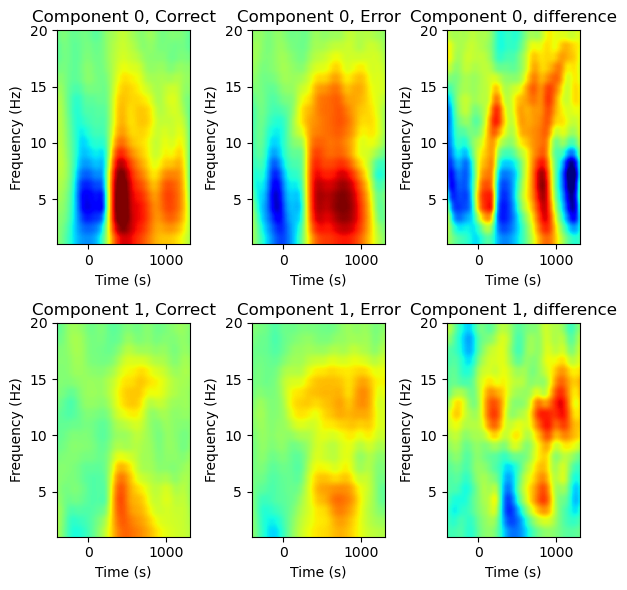

In [22]:
## some plotting

clim = [-10, 10]
condlabels = ['Correct','Error']

_,axs = plt.subplots(2,3,figsize=(6,6))
plotExtent = [ EEG['times'][t2save[0]],EEG['times'][t2save[-1]], frex[0],frex[-1] ]

for compi in range(2):
    for condi in range(3):
        
        
        if (condi+1)%3==0:
            print(compi)
            axs[compi,condi].imshow(2*(ctf[compi,condi-1,:,:]-ctf[compi,condi-2,:,:]),vmin=clim[0],vmax=clim[1],
                            aspect='auto',origin='lower',extent=plotExtent, cmap='jet')
            axs[compi,condi].set_title(f'Component {comps2analyze[compi]}, difference')
            axs[compi,condi].set_xlabel('Time (s)')
            axs[compi,condi].set_ylabel('Frequency (Hz)')
        else:
            print(compi)
            axs[compi,condi].imshow(ctf[compi,condi,:,:],vmin=clim[0],vmax=clim[1],
                                aspect='auto',origin='lower',extent=plotExtent, cmap='jet')
            axs[compi,condi].set_title(f'Component {comps2analyze[compi]}, {condlabels[condi]}')
            axs[compi,condi].set_xlabel('Time (s)')
            axs[compi,condi].set_ylabel('Frequency (Hz)')
        
plt.tight_layout()
plt.show()